In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import anderson_ksamp
import mlflow
import torch
from torch import nn, optim
import torch.utils.data as data_utils
from IPython.display import clear_output
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import Callback
import yaml

from genhack.datasets import StationsDataset
from genhack.models import models
from genhack.utils import *
from run import run

In [3]:
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlflow.db'

Text(0.5, 1.0, 'Stations location')

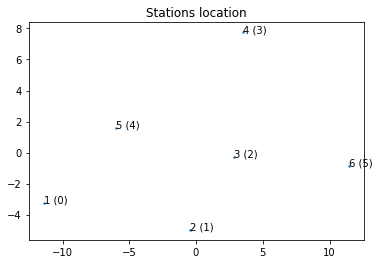

In [237]:
position = np.load('data/position.npy')
lat, lon = position[:6], position[6:]
plt.scatter(lon, lat, s=2)
ad = [0, 1, 2, 3, 4, 5]

for i in range(6):
    plt.annotate(f"{i+1} ({ad[i]})", (lon[i], lat[i]))
plt.title('Stations location')

In [5]:
df_all = pd.read_csv('data/df_all.csv')
df_all['dates'] = pd.to_datetime(df_all['dates'])
df_all = df_all.set_index('dates').sort_index()

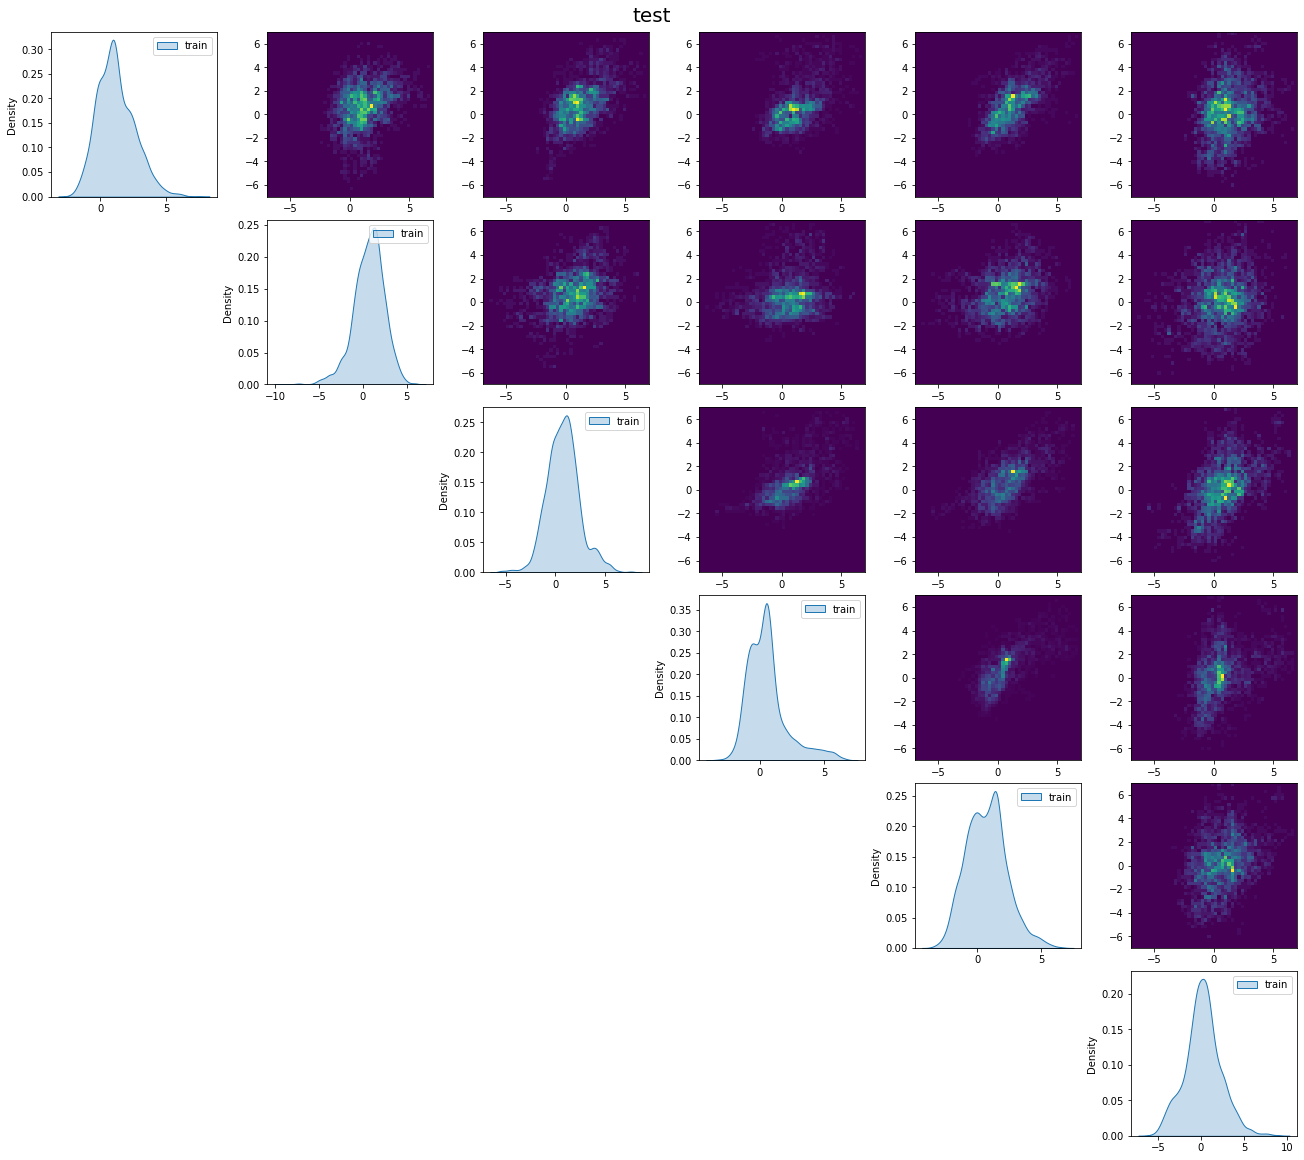

In [6]:
df_test = df_all[df_all.index >= '2008-01-01']

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18, 16), constrained_layout=True)
fig.suptitle('test', fontsize=20)

for i in range(6):
    for j in range(6):
        if i < j:
            ax[i][j].hist2d(df_test[f's{i+1}'], df_test[f's{j+1}'], bins=50, range=[[-7, 7], [-7, 7]])
        if i > j:
            fig.delaxes(ax[i][j])
    sns.kdeplot(data=df_test.to_numpy()[:, i], ax=ax[i][i], fill=True, label='train')
    ax[i][i].legend()


# Train

In [ ]:
with open('configs/cnf.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

class HistCallback(Callback):

    def on_validation_start(self, trainer, pl_module):
        
        dataset = next(iter(trainer.datamodule.val_dataloader()))
        X_val, position, time = dataset[0], dataset[1][0], dataset[2]

        # add dummy position
        n_val_dim = len(position) // 2
        position = torch.cat([position, torch.tensor([0] * 2 * max(trainer.model.model.n_dim - n_val_dim, 0)).float()])

        # predict and cut-off dummy positions
        X_val_pred = trainer.model.model.sample(torch.randn((len(X_val), trainer.model.model.n_latent_dim)), position=position, time=time)
        X_val_pred = X_val_pred[:, :n_val_dim]

        fig = plot_hist2d(X_val_pred, X_val)
                
        clear_output(wait=True)
        plt.show()

        if hasattr(trainer.model.model, 'weights'):
            date_range = pd.date_range(trainer.datamodule.train_start_date, trainer.datamodule.train_end_date, freq='M')
            weights = trainer.model.model.weights(torch.linspace(0, 1, len(date_range))[:, None]).detach().numpy()
            plt.plot(date_range, weights)
            
        print(f"Epoch: {trainer.current_epoch+1}/{trainer.max_epochs}")

with mlflow.start_run() as active_run:
    run(config, enable_progress_bar=True, callbacks=[HistCallback()])

# Plot

In [80]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib

In [11]:
best_model = mlflow.pytorch.load_model("runs:///ae30c842f0ad4c498395b0d2e26a7690/best_ad_mean")

In [22]:
noise = torch.randn((3288, 6))

In [64]:
lat = np.linspace(-12, 12, 6)
lon = np.linspace(-12, 12, 6)

LAT, LON = np.meshgrid(lat, lon)
sst = []

for lat, lon in zip(LAT, LON):
    position = torch.cat([torch.tensor(lat).float(), torch.tensor(lon).float()])
    sst += [best_model.sample(noise, position).detach().numpy()]
    
sst = torch.tensor(sst).permute(1, 0, 2)

In [221]:
position = np.load('data/position.npy')
sst_true = best_model.sample(noise, torch.tensor(position).float()).detach().numpy()

In [180]:
def plot(i):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.contourf(LON, LAT, sst[i], 100)
    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=sst[i].min(), vmax=sst[i].max())
    for j, (lat, lon) in enumerate(zip(position[:6], position[6:])):
        ax.scatter(lon, lat, s=100, c=cmap(norm(sst_true[i][j])), linewidth=1, edgecolor='white')

In [216]:
lat = torch.arange(6).float()
lon = torch.arange(6).float()
pos1 = torch.cat([lat, lon])
pos2 = torch.cat([torch.flip(lat, dims=(0,)), torch.flip(lon, dims=(0,))])

In [217]:
best_model.sample(noise[:1], pos1)

tensor([-2.5928, -0.2054,  1.0063, -1.4478, -0.8398, -6.1052],
       grad_fn=<SqueezeBackward0>)

In [218]:
best_model.sample(noise[:1], pos2)

tensor([-2.2307, -0.0440,  0.2739, -1.9704, -1.0093, -5.5974],
       grad_fn=<SqueezeBackward0>)

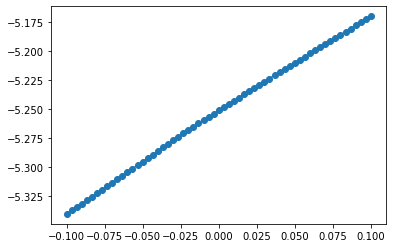

In [222]:
output = np.array([best_model.sample(noise[:1], torch.tensor(position).float() + i).detach().numpy() for i in torch.linspace(-0.1, 0.1, 61)])
plt.plot(torch.linspace(-0.1, 0.1, 61), output[:, 5], marker='o')

In [223]:
interact(plot, i=widgets.IntSlider(min=0, max=len(sst)-1, step=1, value=10))

interactive(children=(IntSlider(value=10, description='i', max=3287), Output()), _dom_classes=('widget-interac…

<function __main__.plot(i)>